<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/330_beta_binomial.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(post-inference-prediction-notebook)=
# Metodi di sintesi della distribuzione a posteriori

L'obiettivo di questo capitolo è analizzare in dettaglio il flusso di lavoro all'interno del contesto dell'inferenza bayesiana, una volta che sia stata ottenuta la stima della distribuzione a posteriori mediante l'utilizzo della tecnica MCMC.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

pd.set_option('display.precision', 2)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
import matplotlib.style as style 
style.use("tableau-colorblind10")

## Campionamento con PyMC

A titolo di esempio, useremo ancora una volta il set di dati "moma_sample", che è stato analizzato nel capitolo precedente. Iniziamo replicando il processo di campionamento PyMC descritto in precedenza.

In [4]:
y = 14
ntrials = 100

alpha_prior = 4
beta_prior = 6

with pm.Model() as bb_model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

In [5]:
with bb_model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:02.090462
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 670.26it/s]

Sampling time =  0:00:03.402772
Transforming variables...
Transformation time =  0:00:00.030133


La figura seguente rappresenta la distribuzione a posteriori di $\theta$ ottenuta mediante il metodo MCMC e la traccia delle catene di Markov.

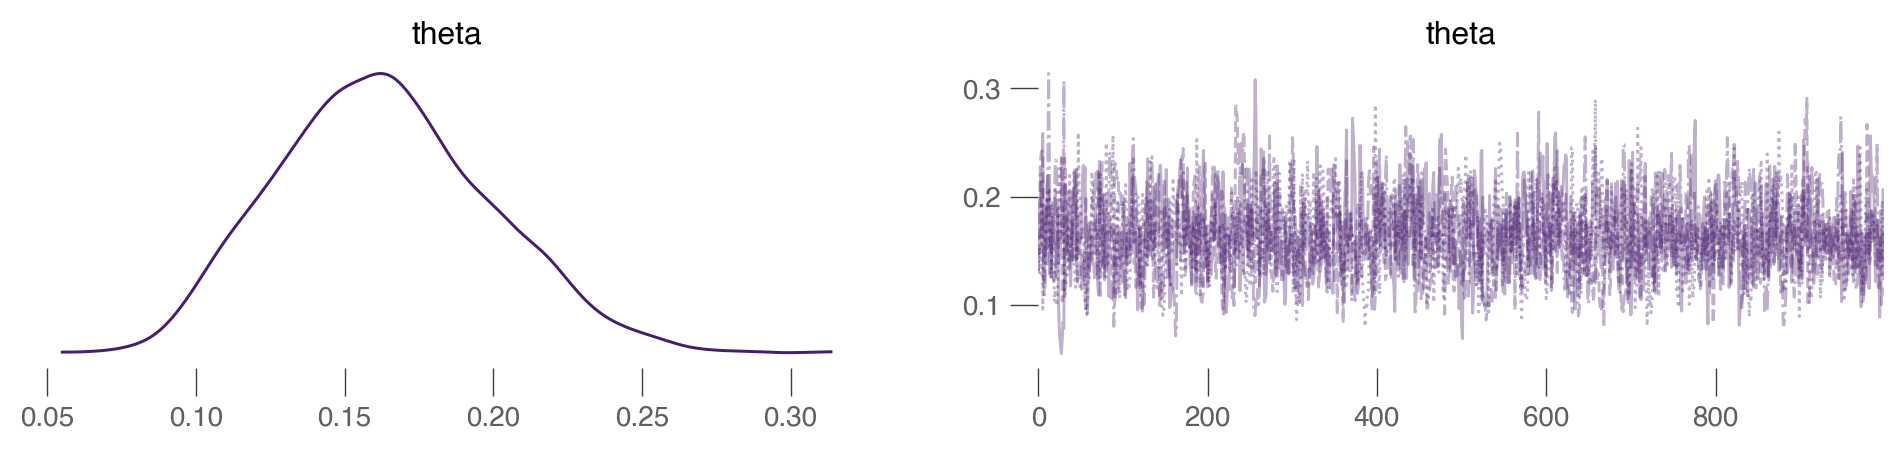

In [12]:
az.plot_trace(idata, combined=True)
plt.show()

## Estrazione degli attributi da `InferenceData`

Ora che abbiamo ottenuto la distribuzione a posteriori, possiamo effettuare varie operazioni con essa:

- Stima puntuale
- Intervalli di credibilità
- Test di ipotesi
- Predizione

## Stima puntuale

Procediamo all'esame dell'oggetto `idata`.

In [9]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

I vari attributi dell'oggetto `InferenceData` possono essere estratti come si farebbe con un `dict`, in cui ciascuna coppia è composta da una chiave e un valore, separati dal simbolo dei due punti. In questa situazione, le chiavi sono i nomi delle variabili, mentre i valori sono rappresentati da array di Numpy. Per esempio, possiamo recuperare la traccia di campionamento dalla variabile latente `theta` nel modo seguente.

In [10]:
idata.posterior["theta"]

<xarray.DataArray 'theta' (chain: 4, draw: 1000)>
array([[0.15913269, 0.14686593, 0.129574  , ..., 0.19272323, 0.18719547,
        0.18719547],
       [0.18684027, 0.17033273, 0.15863134, ..., 0.11933375, 0.11834683,
        0.09752895],
       [0.14444323, 0.15277526, 0.13222572, ..., 0.1074277 , 0.17886942,
        0.15996287],
       [0.22015295, 0.23424492, 0.1553009 , ..., 0.16950917, 0.20250789,
        0.1988639 ]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

Si noti che l'oggetto ritornato è un array di dimensioni 4 $\times$ 1000 (sul mio computer):

In [11]:
idata.posterior["theta"].shape

(4, 1000)

Per visualizzare il primi 10 valori della prima catena, ad esempio, usiamo:

In [12]:
idata.posterior["theta"][0, 1:10]

<xarray.DataArray 'theta' (draw: 9)>
array([0.14686593, 0.129574  , 0.20470065, 0.13314582, 0.12304652,
       0.15890086, 0.16592707, 0.17606413, 0.17804513])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 1 2 3 4 5 6 7 8 9

Per combinare catene e iterazioni, utilizziamo la funzione `arviz.extract()`. 

In [13]:
post = az.extract(idata)
post

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (sample) float64 0.1591 0.1469 0.1296 ... 0.1695 0.2025 0.1989
Attributes:
    created_at:     2023-08-27T06:02:08.514644
    arviz_version:  0.16.1

La funzione `extract` ritorna un oggetto di classe xarray.DataArray il quale può essere trattato come un array NumPy. 

In [14]:
post["theta"]

<xarray.DataArray 'theta' (sample: 4000)>
array([0.15913269, 0.14686593, 0.129574  , ..., 0.16950917, 0.20250789,
       0.1988639 ])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

Si noti che `post["theta"]` contiene il numero totale (4000) dei campioni a posteriori della distribuzione di $\theta$ escluso il burn-in:

In [15]:
post["theta"].shape

(4000,)

Di conseguenza, possiamo calcolare su di esso tutte le misure statistiche descrittive che si possono ottenere da un vettore di dati. Per esempio, possiamo calcolare la media a posteriori.

In [16]:
post.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 0.1628

In [17]:
post["theta"].mean()

<xarray.DataArray 'theta' ()>
array(0.16276409)

Possiamo calcolare la mediana a posteriori di $\theta$.

In [18]:
post.median()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 0.1605

Oppure la deviazione standard della stima a posteriori di $\theta$.

In [19]:
np.std(post["theta"])

<xarray.DataArray 'theta' ()>
array(0.03431728)

## Intervallo di credibilità

L'inferenza bayesiana tramite l'intervallo di credibilità riguarda invece la stima dell'intervallo che contiene il parametro $\theta$ ad un dato livello di probabilità soggettiva. 

Usando `idata`, possiamo ottenere un sommario della distribuzione a posteriori con il metodo `az.summary()`.

In [20]:
az.summary(idata, hdi_prob=0.94, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.16,0.03,0.1,0.23,1.00e-03,1.00e-03,1533.57,2323.54,1.0


Si ottiene così l'intervallo di credibilità a più alta densità a posteriori (HPD) al 94%. Questo intervallo ci informa sul fatto che, a posteriori, possiamo essere certi al 94%, che il vero valore del parametro $\theta$ sia contenuto nell'intervallo [0.103, 0.23].

Dato che, nel caso presente, conosciamo la soluziona analitica, possiamo verificare il risultato precedente calcolando i quantili della distribuzione a posteriori Beta(18, 92) di ordine 0.03 e 0.97.

In [21]:
ll = stats.beta.ppf(0.03, 18, 92)
ul = stats.beta.ppf(0.97, 18, 92)
list([ll, ul])

[0.10303527075398666, 0.23457657606771784]

## Verifica di ipotesi bayesiana

Un secondo tipo di inferenza bayesiana riguarda problemi in cui siamo interessati a valutare la plausibilità che il parametro $\theta$ assuma valori contenuti in un dato intervallo di valori. Per esempio, ci potrebbe interessare l'ipotesi $\theta > 0.5$. In questo caso, possiamo calcolare la probabilità a posteriori che $\theta$ cada nell'intervallo di interesse, integrando la distribuzione a posteriori Beta su tale intervallo.

Nel caso dell'esempio degli artisti della Generazione X, supponiamo di essere interessati alle due seguenti ipotesi:

$$
\begin{split}
H_0: & \; \; \pi \ge 0.2 \\
H_a: & \; \; \pi < 0.2
\end{split}
$$

La nostra domanda è la seguente: Date le nostre credenze iniziali e i dati disponibili, quale importanza relativa possiamo attribuire a queste due ipotesi?

Per affrontare questa questione, iniziamo a calcolare la probabilità $P(\theta < 0.2)$.

In [22]:
print(np.mean(post["theta"] < 0.2))

<xarray.DataArray 'theta' ()>
array(0.8595)


Passiamo ora a calcolare gli odds a posteriori:

In [23]:
post_odds = (np.mean(post["theta"] < 0.2)) / (1 - np.mean(post["theta"] < 0.2))
print(post_odds)

<xarray.DataArray 'theta' ()>
array(6.11743772)


Ciò implica che la probabilità che $\pi$ sia inferiore al 20% è circa 6 volte superiore rispetto alla probabilità che sia al di sopra del 20%.

Questo risultato si basa solo sulle informazioni relative alla distribuzione a posteriori. Prima di avere osservato i dati del campione, avevamo una distribuzione a priori $\operatorname{Beta}(6, 4)$, e in quel contesto avevamo una probabilità del 9% che $H_a$ fosse vera e una probabilità del 91% che fosse falsa.

In [24]:
threshold = 0.2
prior_prob = stats.beta.cdf(threshold, a=alpha_prior, b=beta_prior)

In [25]:
prior_odds = prior_prob / (1 - prior_prob)
print(prior_odds)

0.09366320688790145


Ora possiamo combinare le informazioni degli odds a posteriori e degli odds a priori in una quantità chiamata *Bayes Factor*, che è semplicemente il rapporto tra le due:

In [26]:
BF = post_odds / prior_odds
print(BF)

<xarray.DataArray 'theta' ()>
array(65.3131355)


In conclusione, dopo aver appreso informazioni riguardo a 14 artisti appartenenti alla generazione X, le probabilità posteriori della nostra ipotesi $H_a: \; \pi < 0.2$ sono circa 60 volte superiori rispetto alle probabilità a priori.

Questo è un esempio di test di ipotesi bayesiano.

## Commenti e considerazioni finali 

In questo capitolo sono state presentate le strategie per la trasformazione della distribuzione a posteriori. Sono state esplorate le diverse modalità per ottenere un intervallo di credibilità. In seguito, è stata affrontata l'analisi delle ipotesi a posteriori. Questo approccio permette di comparare in maniera relativa due ipotesi contrapposte riguardanti il parametro $\theta$. In alcune circostanze, tale confronto viene tradotto in una misura denominata Fattore di Bayes.

## Watermark

In [27]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Aug 27 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.14.0

scipy     : 1.11.2
seaborn   : 0.12.2
arviz     : 0.16.1
pandas    : 2.0.3
matplotlib: 3.7.2
pymc      : 5.7.2
numpy     : 1.25.2

Watermark: 2.4.3

